In [36]:
from langchain.agents import initialize_agent, AgentType, Tool
from langchain.memory import ConversationBufferMemory
from langgraph.graph import StateGraph
from langchain.chat_models import ChatOpenAI
from langchain_gigachat.chat_models import GigaChat
from langchain.schema import HumanMessage, SystemMessage, Document, AIMessage
from langchain.vectorstores import FAISS
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.chains import RetrievalQA
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.types import Command

from langgraph.graph import StateGraph, END, MessagesState, START
from typing import TypedDict, Optional, Literal, List, Dict
from typing_extensions import TypedDict


import warnings
import os
import re

In [2]:
warnings.filterwarnings("ignore")

In [13]:
os.environ["GIGACHAT_CREDENTIALS"] = "Yjc1YWZhNTItMzYwYS00NmU4LTk4YjctZjU4YzAwMDIyMGJmOjJhNWE3YmVhLTAyYzctNGJhNy05NWE3LWEzY2YwNGQzYzZiNw=="

In [14]:
# os.environ["GIGACHAT_CREDENTIALS"] = gigakey_b64
llm = GigaChat(
    model="GigaChat-2-Max",
    verify_ssl_certs=False,
    profanity_check=False,
    streaming=False,
    max_tokens=8192,
    temperature=0.3,
    repetition_penalty=1.01
)

In [15]:
conversation = [
    HumanMessage(content="Кто ты?")
]

In [16]:
result = llm.invoke(conversation)

In [18]:
result.content

'Я — GigaChat, нейросетевой помощник, созданный компанией Sber в России. Я умею решать задачи, отвечать на вопросы, помогать с программированием, математикой, генерацией контента и многим другим. Мы можем обсудить любые темы, решить проблемы или просто пообщаться.'

In [20]:
tools = []

In [35]:
memory_schema = ConversationBufferMemory(memory_key="chat_history")
memory_describer = ConversationBufferMemory(memory_key="chat_history")
memory_graph = ConversationBufferMemory(memory_key="chat_history")


process_describe_agent = initialize_agent(
    tools=tools,
    llm=llm,
    memory = memory_describer,
    agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)

graph_maker_agent = initialize_agent(
    tools=tools,
    llm=llm,
    memory = memory_graph,
    agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)

schema_agent = initialize_agent(
    tools=tools,
    llm=llm,
    memory = memory_schema,
    agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)

In [38]:
class AgentState(TypedDict):
    task: str
    messages: List
    description: str
    graph: str
    schema: str
    
class ValidatorResponse(TypedDict):
    """В поле instructions нужно указать рекомендации. В поле status указать статус задачи [FAIL, SUCCESS]"""
    instructions: str
    status: Literal["FAIL", "SUCCESS"]

In [39]:
def describe_agent_node(state:AgentState)->Command[Literal["describtion_validator"]]:    
    if "messages" in state and state["messages"]:
        old_messages = state["messages"]
        request = state["messages"][-1].content
    else:
        old_messages = []
        request = describer_prompt.format(task=state["task"], instruments=instruments)
    
    response = process_describe_agent.run(request)
    if isinstance(response, dict):
        result = response["output"]
    else:
        result = response
    return Command(
        update={
            "description": result,
            "messages": old_messages + [HumanMessage(content=result, name="Аналитик")]
        },
        goto="describtion_validator"
    )

def describtion_validator_node(state:AgentState)->Command[Literal["describer", "graph_maker_agent"]]:
    return_node = "describer"
    if not "messages" in state or not state["messages"]:
        return Command(goto=return_node)
    
    prompt = description_validator_prompt.format(task=state["task"], format=format_)
    system = SystemMessage(content=prompt)
    request = [system] + [state["messages"][-1]]

    validator_msgs_fount = len(list(filter(lambda x: x.name=="Валидатор", state["messages"])))
    
    response = llm_max.invoke(request)
    response = response.content
    print(f"RESPONSE: {response}")
    match_json = re.search(r'```json\s*(.*?)\s*```', response, re.DOTALL)
    if match_json:
        response = eval(match_json.group(1))
    else:
        response = {"status":"SUCCESS", "instructions":""}
    result = response["instructions"]
    print(f"STATUS: {response['status']}\n\nVALIDATOR: {result}")
    
    if response["status"]=="SUCCESS" or validator_msgs_fount+1 > 3:
        goto = "graph_maker_agent"
        return Command(
            update={
            "messages": [],
            },
            goto=goto
        )
    else:
        goto = return_node
        return Command(
            update={
            "messages": state["messages"] + [HumanMessage(content=result, name="Валидатор")],
            },
            goto=goto
        )
    
def graph_maker_agent_node(state:AgentState)->Command[Literal[END]]:
    if "messages" in state and state["messages"]:
        request = state["messages"][-1].content
    else:
        request = graph_maker_prompt.format(task=state["task"], description=state["description"])
    
    response = graph_maker_agent.run(request)
    if isinstance(response, dict):
        result = response["output"]
    else:
        result = response
    return Command(
        update={
            "graph": result
        },
        goto=END
    )

# def schema_agent_node(state:AgentState)->Command[Literal["schema_validator"]]:
#     if "messages" in state and state["messages"]:
#         request = state["messages"][-1].content
#         old_messages = state["messages"]
#     else:
#         old_messages = []
#         request = schema_agent_prompt.format(description=state["description"], graph=state["graph"])
#     response = schema_agent.run(request)
#     if isinstance(response, dict):
#         result = response["output"]
#     else:
#         result = response
#     return Command(
#         update={
#             "schema": result,
#             "messages": old_messages + [HumanMessage(content=result, name="Аналитик")]
#         },
#         goto="schema_validator"
#     )

# def schema_validator_node(state:AgentState)->Command[Literal["schema_agent", END]]:
#     return_node = "schema_agent"
#     if "messages" in state and state["messages"]:
#         # print(state["messages"])
#         prompt = schema_validator_prompt.format(description=state["description"], graph=state["graph"])
#         request = [SystemMessage(content=prompt)] + state["messages"]
#         old_messages = state["messages"]
#     else:
#         return Command(goto=return_node)

#     validator_msgs_fount = len(list(filter(lambda x: x.name=="Валидатор", state["messages"])))
#     response = llm_max.with_structured_output(ValidatorResponse).invoke(request)
#     result = response["instructions"]
    
#     if response["status"]=="SUCCESS" or validator_msgs_fount+1 > 3:
#         goto = END
#     else:
#         goto = return_node
#     print(f"STATUS: {response['status']}\n\nVALIDATOR: {result}")
#     return Command(
#         update={
#             "messages": old_messages + [HumanMessage(content=result, name="Валидатор")],
#         },
#         goto=goto
#     )

In [40]:
def make_graph(mapper, entry_point, state_schema):
    builder = StateGraph(state_schema=state_schema)
    builder.set_entry_point(entry_point)
    for name, node in mapper.items():
        builder.add_node(name, node)
    graph = builder.compile()
    return graph

In [41]:
graph_mapper = {
    "describer": describe_agent_node,
    "describtion_validator": describtion_validator_node,
    "graph_maker_agent": graph_maker_agent_node,
}

In [42]:
graph = make_graph(mapper=graph_mapper, entry_point="describer", state_schema=AgentState)

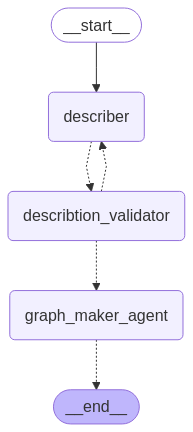

In [43]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [44]:
instruments = """RAG - поиск аналогичных решений по своей базе данных для более корректной генерации;
Web Search - поиск в интернете, если требуется найти актуальную информацию;
API - взаимодействие со сторонними сервисами через API."""

In [45]:
describer_prompt = """Ты - превосходный аналитик. Тебе дается задача {task}. Тебе нужно придумать и описать, как реализовать эту задачу с помощью llm агентов.
Подумай над следующими вопросами: 
- Как придуманная система будет взаимодействовать со сторонними системами (из какой системы будет приходить запрос, куда будет отправляться результат);
- Сколько агентов необходимо для реализации системы: один или несколько; 
- Нужен ли агент оркестратор или можно обойтись без него (Агент оркестратор может быть необходим, если требуется координировать работу нескольких агентов, которые работают вместе);
- Нужен ли агент валидатор или можно обойтись без него (Агент валидатор может быть необходим, если нужно провалидировать работу другого агента и, если работа не соответствует критериям, вернуть задачу на доработку); 
- Какую задачу решает каждый агент, какие инструменты из перечня инструментов {instruments} ему необходимы для решения его задачи;
- С какими системами будет взаимодействовать каждый агент;


Опиши придуманный тобой процесс.
"""

In [46]:
description_validator_prompt = """Ты - Валидатор. Ты прекрасно умеешь критиковать написанные сценарии для достижения наилучшего результата.
Ты работаешь вместе с Аналитиком. Проанализуруй сценарий, который предложил аналитик к задаче {task}. 
Сценарий не должен быть очень подробным: не должны быть описаны контракты между сервисами, структура БД, метрики качества. Должна быть отражена только основная суть. 
Проверь, что сценарий, который предложил аналитик подходит для решения задачи. 
Проверь, что описаны как основные сценарии, так и альтернативные.
Если сценарий нужно улучшать, напиши свои замечания и верни сценарий на дорабоку, ответив FAIL В конце инструкции попроси аналитика заново полностью описать сценарий. 
Если Аналитик хорошо выполнил свою работу и замечаний нет, ответь SUCCESS.

Ответ дай в следующем формате json:
{format}
"""

In [47]:
format_ ="""{
    "instructions": "Здесь укажи свои рекомендации или оставь строку пустой, если рекомендаций нет",
    "status": "FAIL" если требуется доработка иначе "SUCCESS"
}"""

In [48]:
graph_maker_prompt = """Ты - превосходный аналитик. Тебе дается задача {task} и описание ее решения {description}.
Выдели основные объекты системы и опиши граф связей между объектами. Если в процессе упомянуты инструменты, изобрази их. Граф должен включать как основной так и альтернативные сценарии.
Граф должент быть простой и понятный, изображать только основные этапы взаимодействия без чрезмерных подробностей.
Для наглядности изобрази схему в формате markdown"""

In [49]:
task_3 = """Требуется создать систему автозаполнения заявок инженеров сопровождения. Как должна работать система:
Есть база данных "ПКАП", с которой можно взаимодействовать через сторонний сервис OpenShift. Сервис Openshift извлекает данные из БД и отдает их системе.
Данные представляют собой заявку по инциденту, которые необходимо заполнить. Система должна проанализировать заявку, выделить причины инциденда и способ его закрытия.
Система должна сравнить проанализированные данные с аналогичными примерами, которые у нее есть. В случае, если найден похожий пример, заполнить заявку основываясь на примере и результаете своего анализа."""

In [50]:
initial_state = {
    "task": task_3,
}

In [51]:
memory_describer.clear()
memory_graph.clear()
memory_schema.clear()

In [55]:
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

In [56]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Разбей задачу на подзадачи и пошагово решай ее. \
                    Если для решения поставленного вопроса нужна информация, задай уточняющий \
                    вопрос в формате [Для решения вопроса мне не хватает информации: информация]"),
        ("placeholder", "{messages}"),
    ]
)

In [59]:
describer_agent_gigachat = create_react_agent(model=llm, tools=[], prompt=prompt)

In [74]:
graph_maker_agent_gigachat = create_react_agent(model=llm, tools=[], prompt=prompt)

In [66]:
messages = {
    "messages": [
        HumanMessage(content=describer_prompt.format(task=initial_state["task"], instruments=instruments))
    ]
}

In [67]:
describer_result = describer_agent_gigachat.invoke(messages)

In [75]:
messages_2 = {
    "messages": [
        HumanMessage(content=describer_result["messages"][1].content)
    ]
}

In [76]:
graph_maker_result = graph_maker_agent_gigachat.invoke(messages_2)

In [81]:
with open("giga_graph.txt", "w") as f:
    f.write(graph_maker_result["messages"][1].content)

In [82]:
with open("giga_desc.txt", "w") as f:
    f.write(describer_result["messages"][1].content)

In [80]:
graph_maker_result["messages"][1].content

'### Шаги для реализации системы автозаполнения заявок инженеров сопровождения:\n\n#### 1. Анализ задачи и постановка целей\n- Определить требования к системе автозаполнения заявок.\n- Определить источники данных (база данных "ПКАП", сервис OpenShift).\n- Определить формат взаимодействия с инженерами сопровождения.\n\n#### 2. Взаимодействие со сторонними системами\n- Реализовать интерфейс для приема заявок от инженеров сопровождения.\n- Реализовать интерфейс для отправки заполненных заявок инженерам сопровождения.\n\n#### 3. Необходимость агентов\n- Разработать агента-анализатора для анализа заявок.\n- Разработать агента-поисковика для поиска аналогичных примеров.\n- Разработать агента-заполнителя для заполнения заявок.\n- Разработать агента-оркестратора для координации работы агентов.\n- Разработать агента-валидатора для проверки корректности заполнения заявок.\n\n#### 4. Необходимость агента-оркестратора\n- Определить задачи и инструменты агента-оркестратора.\n- Реализовать координац

In [73]:
print(describer_result["messages"][1].content)

### 1. Анализ задачи и постановка целей
Система автозаполнения заявок инженеров сопровождения должна:
- Получать данные заявки по инциденту из базы данных "ПКАП" через сервис OpenShift.
- Анализировать заявку, выделяя причины инцидента и способ его закрытия.
- Сравнивать проанализированные данные с аналогичными примерами, которые у нее есть.
- В случае нахождения похожего примера, заполнять заявку на основе примера и результата анализа.

### 2. Взаимодействие со сторонними системами
- **Запрос**: Запрос на анализ и автозаполнение заявки приходит от инженера сопровождения через интерфейс системы.
- **Результат**: Заполненная заявка отправляется обратно инженеру сопровождения через интерфейс системы.

### 3. Необходимость агентов
Для реализации системы потребуется несколько агентов:
- **Агент-анализатор**: анализирует заявку, выделяет причины инцидента и способ его закрытия.
- **Агент-поисковик**: ищет аналогичные примеры в базе данных.
- **Агент-заполнитель**: заполняет заявку на основе